In [1]:
import numpy as np
import scipy.integrate as integrate
import matplotlib
import matplotlib.pyplot as plt
import numpy.polynomial as poly

[0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]


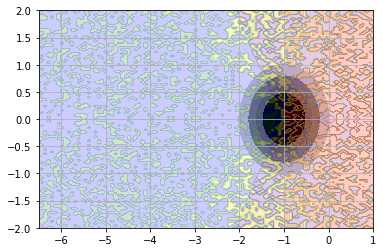

In [4]:
# Forward Euler
#sigma_p = poly.Polynomial([1., 0.])
#rho_p = poly.Polynomial([-1., 1.])
# Backward Euler
#sigma_p = poly.Polynomial([0., 1.])
#rho_p = poly.Polynomial([-1., 1.])
# Trapezoidal method
#sigma_p = poly.Polynomial([0.5, 0.5])
#rho_p = poly.Polynomial([-1., 1.])
# One step late method
#sigma_p = poly.Polynomial([1., 0., 0.])
#rho_p = poly.Polynomial([-1., 0., 1.])
# One step late implicit
#sigma_p = poly.Polynomial([0., 0., 1.])
#rho_p = poly.Polynomial([-1., 0., 1.])
# Approximate sfc_flux_avg
n_terms = 40
res_n_terms = 0#n_terms - 1
dt_tweak = 0.25
sigma_terms = 0.5**np.linspace(n_terms-1, 0., n_terms)
sigma_terms[-1] = 0.
#sigma_p = poly.Polynomial(sigma_terms)
rho_terms = np.zeros((n_terms,))
rho_terms[-1] = 1.
rho_terms[-2] = -1.
#rho_p = poly.Polynomial(rho_terms)
def calc_res_terms(z, dt_tweak, res_n_terms=n_terms-1):
    res_terms = np.zeros((n_terms,), dtype=np.complex)
    utilde = 0.5**np.linspace(n_terms-1, 0., n_terms, dtype=np.complex)
    for i in range(res_n_terms):
        res_terms[n_terms-2-i] = (1. - dt_tweak)**i
    offset = 0 #n_terms-1 - res_n_terms
    for i in range(res_n_terms):
        res_terms[offset:n_terms-1-i] -= (1. - dt_tweak)**i * utilde[offset+i:n_terms-1]
    return res_terms
# Two term smoothing
c1 = 0.75
#sigma_p = poly.Polynomial([(1.-c1), c1, 0.])
#rho_p = poly.Polynomial([0., -1., 1.])
# Repeated smoothing
c1 = 2./3.
nterms = 20
#sigma_p = poly.Polynomial([(1.-c1)**(nterms - i - 1) * (1. if i == 0 else c1) for i in range(nterms)] + [0.])
#rho_p = poly.Polynomial([0.] * (nterms-1) + [-1., 1.])
# Three term smoothing
#c1 = 6./10.
#c2 = 0.75
#sigma_p = poly.Polynomial([(1.-c1)*(1.-c2), c2*(1.-c1), c1, 0.])
#rho_p = poly.Polynomial([0., 0., -1., 1.])
def largest_mag_root(p):
    roots = p.roots()
    if len(roots) != 0:
        i = np.abs(roots).argmax()
        return roots[i]
    else:
        return None

def period(big_root):
    if np.imag(big_root) >= 0.:
        root = big_root
    else:
        root = np.conj(big_root)
    ang = np.angle(root)
    if ang == 0.:
        return 1.e10
    else:
        return 2.*np.pi / ang

n_points = 101
xs = np.linspace(-6.5, 1., n_points)
#xs = np.linspace(-4., 4., n_points)
ys = np.linspace(-2., 2., n_points)
#xs = np.linspace(-40., 40., n_points)
#ys = np.linspace(-20., 20., n_points)
abs_gams = np.zeros((n_points, n_points))
periods = np.zeros((n_points, n_points))
print(calc_res_terms(-1., dt_tweak, res_n_terms))
for i in range(n_points):
    for j in range(n_points):
        z = xs[i] + ys[j]*1.j
        res_terms = calc_res_terms(z, dt_tweak, res_n_terms)
        p = -z*sigma_p + rho_p - z*dt_tweak*res_terms
        big_root = largest_mag_root(p)
        if big_root is not None:
            abs_gams[j,i] = np.abs(big_root)
            periods[j,i] = period(big_root)
        else:
            abs_gams[j,i] = 1.e10
            periods[j,i] = 1.e10
plt.contourf(xs, ys, abs_gams, levels=np.array([0., 0.7, 0.8, 0.9, 1.]), colors=['black', 'dimgrey', 'grey', 'lightgrey'])
plt.contourf(xs, ys, periods, levels=np.array([2., 3., 4., 5., 6., 8., 1.e20]),
             colors=['purple', 'blue', 'green', 'yellow', 'orange', 'red'], alpha=0.2)
plt.grid()
#plt.savefig('smooth35.png')

In [3]:
f = 0.6 + 0.j
x = 2.5
first_term = (1. - f*x) / 2.
second_term = np.sqrt(1. - 4.*x + 2.*f*x + f*f*x*x) / 2.
print(first_term - second_term, first_term + second_term)
print(max_abs_gam(2.5))

(-0.25-0.9682458365518543j) (-0.25+0.9682458365518543j)
1.0


0.7499999999999999


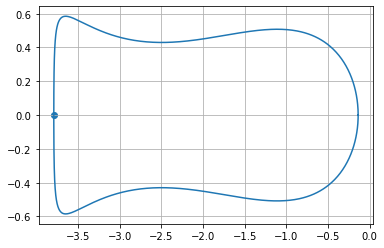

In [67]:
c1 = 2/3
c2 = 0.25 / (1. - c1)
def p(z):
    return z**3 - z**2

def sigma(z):
    return c1 * z**2 + (1. - c1) * c2 * z + (1. - c1) * (1. - c2)

def locus_compute(theta):
    eit = 0.85*np.exp(1.j * theta)
    return p(eit) / sigma(eit)

num_points = 1001
thetas = np.linspace(0., 2.*np.pi, num_points) + 0.j
loci = locus_compute(thetas)
plt.plot(loci.real, loci.imag)
plt.scatter(loci[num_points//2].real, loci[num_points//2].imag)
plt.grid()
print(c2)

In [227]:
def vareps(c1, c2, M):
    fac = (c2/c1)**M
    return 1 + fac + (1. - fac) / (M * (c2 - c1))

for M in range(1000, 1010):
    p = poly.Polynomial([(M - l) for l in range(M)]) - poly.Polynomial([M*M])
    for root in p.roots():
        if root.imag == 0 and root.real > 1.:
            print(M, root.real, vareps(root.real, 1., M), vareps(1.00000001, 1., M))
            break

1000 1.0017937596108901 0.7019910144163166 0.9999950061345879
1001 1.0017919671668825 0.7019905983816831 0.9999950011378123
1002 1.001790178301557 0.7019901831771111 0.9999949961310504
1003 1.0017883930042017 0.7019897688001182 0.9999949911364703
1004 1.0017866112641627 0.7019893552482354 0.9999949861319195
1005 1.0017848330708121 0.701988942519035 0.9999949811395219
1006 1.0017830584135743 0.7019885306099929 0.999994976137169
1007 1.0017812872819065 0.7019881195187369 0.9999949711359158
1008 1.0017795196653148 0.7019877092428016 0.9999949661357588
1009 1.0017777555533494 0.7019872997797485 0.9999949611366946


In [212]:
np.sqrt(7.) - 1.

1.6457513110645907

In [221]:
np.sqrt(0.5)

0.7071067811865476

502002


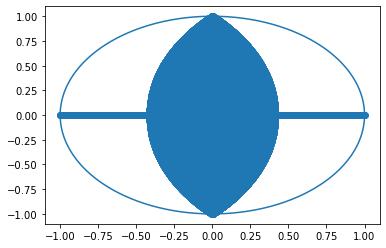

In [41]:
one_grid = np.linspace(0., 1., 501) + 0.j
points = []
for x in one_grid:
    for y in one_grid:
        center = x - y
        root = np.sqrt(center*center - 4.*x*y)
        points.append((center + root)*0.5)
        points.append((center - root)*0.5)
points = np.array(points)
print(len(points))
plt.scatter(points.real, points.imag)
plt.plot(np.sin(one_grid.real * 2. *np.pi), np.cos(one_grid.real * 2. * np.pi))

2060602


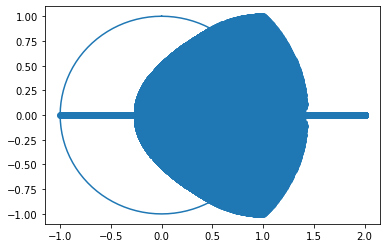

In [255]:
one_grid = np.linspace(0., 1., 101) + 0.j
points = []
for x in one_grid:
    for z in one_grid:
        for y in one_grid:
            #if y > z:
            #    continue
            center = x - y + 2.*z
            root = np.sqrt(center*center - 8.*x*z)
            points.append((center + root)*0.5)
            points.append((center - root)*0.5)
points = np.array(points)
print(len(points))
plt.scatter(points.real, points.imag)
plt.plot(np.sin(one_grid.real * 2. *np.pi), np.cos(one_grid.real * 2. * np.pi))